# Parte 1. Priorizar Hipotesis

In [1]:
import pandas as pd

# Cargar los datos de hipótesis
hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', delimiter=';')

# Mostrar información del dataframe
print(hypotheses.head())

print(hypotheses.columns)  

                                          Hypothesis  Reach  Impact  \
0  Add two new channels for attracting traffic. T...      3      10   
1  Launch your own delivery service. This will sh...      2       5   
2  Add product recommendation blocks to the store...      8       3   
3  Change the category structure. This will incre...      8       3   
4  Change the background color on the main page. ...      3       1   

   Confidence  Effort  
0           8       6  
1           4      10  
2           7       3  
3           3       8  
4           1       1  
Index(['Hypothesis', 'Reach', 'Impact', 'Confidence', 'Effort'], dtype='object')


# 1.1 Framework ICE

In [2]:
# Calcular ICE
hypotheses['ICE'] = (hypotheses['Reach'] * hypotheses['Impact'] * hypotheses['Confidence']) / hypotheses['Effort']

# Ordenar por ICE en orden descendente
ice_sorted = hypotheses.sort_values(by='ICE', ascending=False)
print("Prioridad según el framework ICE:")
print(ice_sorted[['Hypothesis', 'ICE']])




Prioridad según el framework ICE:
                                          Hypothesis    ICE
7  Add a subscription form to all the main pages....  112.0
2  Add product recommendation blocks to the store...   56.0
0  Add two new channels for attracting traffic. T...   40.0
6  Show banners with current offers and sales on ...   40.0
8  Launch a promotion that gives users discounts ...   16.2
3  Change the category structure. This will incre...    9.0
1  Launch your own delivery service. This will sh...    4.0
5  Add a customer review page. This will increase...    4.0
4  Change the background color on the main page. ...    3.0


In [3]:

# Calcular RICE
hypotheses['RICE'] = (hypotheses['Reach'] * hypotheses['Impact'] * hypotheses['Confidence']) / hypotheses['Effort']

# Ordenar por RICE en orden descendente
rice_sorted = hypotheses.sort_values(by='RICE', ascending=False)
print("Prioridad según el framework RICE:")
print(rice_sorted[['Hypothesis', 'RICE']])



Prioridad según el framework RICE:
                                          Hypothesis   RICE
7  Add a subscription form to all the main pages....  112.0
2  Add product recommendation blocks to the store...   56.0
0  Add two new channels for attracting traffic. T...   40.0
6  Show banners with current offers and sales on ...   40.0
8  Launch a promotion that gives users discounts ...   16.2
3  Change the category structure. This will incre...    9.0
1  Launch your own delivery service. This will sh...    4.0
5  Add a customer review page. This will increase...    4.0
4  Change the background color on the main page. ...    3.0


<div class="alert alert-block alert-success">
<b>Celda [3]</b> <a class="tocSkip"></a><br>
Has calculado correctamente el valor RICE y ordenado las hipótesis en función de este valor. Esto es crucial para priorizar las acciones basadas en el impacto potencial y el esfuerzo requerido. Asegurarte de que las hipótesis más prometedoras se evalúen primero puede optimizar los recursos y el tiempo del proyecto.
</div>


# Análisis de Cambios en la Prioridad

# Consistencia en las Primeras Posiciones:

### En ambos marcos (ICE y RICE), las primeras posiciones se mantienen iguales. La hipótesis “Add a subscription form to all the main pages” tiene el puntaje más alto en ambos casos. Esto sugiere que esta hipótesis es considerada valiosa bajo ambos marcos de priorización.

# Influencia del Alcance en RICE:

### En RICE, si se considera que hay un número significativo de usuarios que se puede alcanzar, las hipótesis con un alto impacto y alcance pueden sumar significativamente en comparación con ICE que no tiene en cuenta el alcance de la misma manera.
### Sin embargo, en este caso, el cálculo de RICE no parece estar mostrando un cambio en el ranking porque user_count es fijo, pero si se variara para incluir diferentes hipótesis que afecten más o menos a diferentes segmentos, el orden podría cambiar.

# Interpretación del Alcance:

### El alcance se refiere a la cantidad de usuarios que se espera que se vean afectados por la hipótesis. Si consideramos que el alcance puede variar drásticamente según la estrategia que se elija, el RICE se vuelve especialmente importante para medir resultados a gran escala y puede alterar las decisiones de priorización si hay hipótesis que afectan a más usuarios.

# Conclusión

### Al usar ICE o RICE, las decisiones sobre las hipótesis pueden variar. Es vital entender cuál de estos enfoques se alinea mejor con los objetivos específicos del negocio y el contexto en el que se está operando. Si bien ICE proporciona una priorización rápida centrada en el impacto inmediato, RICE ofrece un enfoque más matizado al considerar el número de usuarios potencialmente impactados, lo que puede ser especialmente útil en pruebas a gran escala.

# Parte 2. Análisis del test A/B

## 1.1 Procesamiento y limpieza de datos

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Cargar los datos
orders = pd.read_csv('/datasets/orders_us.csv')
visits = pd.read_csv('/datasets/visits_us.csv')

# Mostrar las primeras filas de cada dataframe para verificar la carga

print(orders.head())
print()
print(visits.head())

   transactionId   visitorId        date  revenue group
0     3667963787  3312258926  2019-08-15     30.4     B
1     2804400009  3642806036  2019-08-15     15.2     B
2     2961555356  4069496402  2019-08-15     10.2     A
3     3797467345  1196621759  2019-08-15    155.1     B
4     2282983706  2322279887  2019-08-15     40.5     B

         date group  visits
0  2019-08-01     A     719
1  2019-08-02     A     619
2  2019-08-03     A     507
3  2019-08-04     A     717
4  2019-08-05     A     756


In [5]:
# Verificar duplicados en orders
duplicate_orders = orders.duplicated().sum()
print(f"Número de duplicados en orders: {duplicate_orders}")

# Verificar duplicados en visits
duplicate_visits = visits.duplicated().sum()
print(f"Número de duplicados en visits: {duplicate_visits}")

# Eliminar duplicados si es necesario
orders = orders.drop_duplicates()
visits = visits.drop_duplicates()



Número de duplicados en orders: 0
Número de duplicados en visits: 0


In [6]:
# Comprobar si hay usuarios en ambos grupos
conflicting_groups = orders.groupby('visitorId')['group'].nunique()
conflicting_visitors = conflicting_groups[conflicting_groups > 1].index.tolist()
print(f"Número de visitantes en ambos grupos: {len(conflicting_visitors)}")

Número de visitantes en ambos grupos: 58


In [7]:
# Filtrar órdenes para eliminar visitantes en ambos grupos
orders = orders[~orders['visitorId'].isin(conflicting_visitors)]

In [8]:
# Verificar tipos de datos para ambos DataFrames
print("Tipos de datos de órdenes:")
print(orders.dtypes)
print("\nTipos de datos de visitas:")
print(visits.dtypes)

# Convertir la columna 'date' a tipo datetime
orders['date'] = pd.to_datetime(orders['date'])
visits['date'] = pd.to_datetime(visits['date'])

Tipos de datos de órdenes:
transactionId      int64
visitorId          int64
date              object
revenue          float64
group             object
dtype: object

Tipos de datos de visitas:
date      object
group     object
visits     int64
dtype: object


In [9]:
 # Resumen de ingresos por grupo
revenue_summary = orders.groupby('group')['revenue'].sum()
print("Resumen de ingresos por grupo:")
print(revenue_summary)

# Resumen de visitas por grupo
visits_summary = visits.groupby('group')['visits'].sum()
print("\nResumen de visitas por grupo:")
print(visits_summary)



Resumen de ingresos por grupo:
group
A    53212.0
B    79651.2
Name: revenue, dtype: float64

Resumen de visitas por grupo:
group
A    18736
B    18916
Name: visits, dtype: int64


# 2.1 Ingreso Acumulado por Grupo

## Cálculo del Ingreso Acumulado

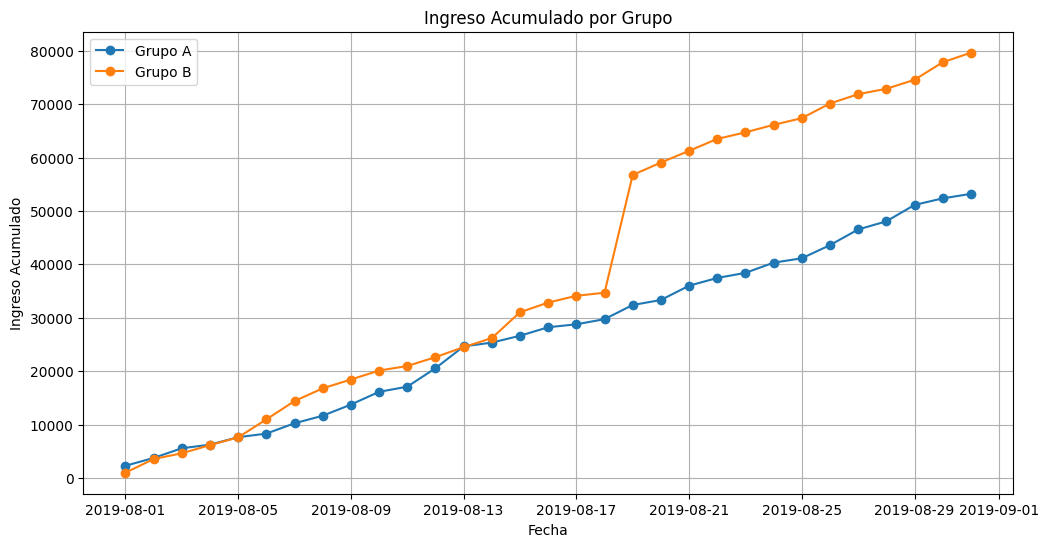

In [10]:

# Agrupar por fecha y grupo para obtener ingresos acumulados
revenue_by_date_group = orders.groupby(['date', 'group'])['revenue'].sum().unstack()

# Calcular ingresos acumulados
revenue_cumsum = revenue_by_date_group.cumsum()

# Graficar ingresos acumulados
plt.figure(figsize=(12, 6))
plt.plot(revenue_cumsum.index, revenue_cumsum['A'], label='Grupo A', marker='o')
plt.plot(revenue_cumsum.index, revenue_cumsum['B'], label='Grupo B', marker='o')
plt.title('Ingreso Acumulado por Grupo')
plt.xlabel('Fecha')
plt.ylabel('Ingreso Acumulado')
plt.legend()
plt.grid()
plt.show()

## Conclusiones 

### * Ingreso Acumulado: El gráfico muestra la evolución del ingreso acumulado para dos grupos, "Grupo A" y "Grupo B", durante el mes de agosto de 2019.
### * Dominio del Grupo B: A lo largo de todo el período, el "Grupo B" (representado por los puntos naranjas) siempre tuvo un ingreso acumulado mayor que el "Grupo A" (representado por los puntos azules).
### * Ritmo de crecimiento inicial: Desde el 1 de agosto hasta aproximadamente el 13 de agosto, ambos grupos mostraron un crecimiento relativamente similar, con el "Grupo B" manteniendo una ligera ventaja constante.
### * Aceleración en el Grupo B: Entre el 13 y el 17 de agosto, el "Grupo B" experimentó una aceleración significativa en su ingreso acumulado, lo que aumentó considerablemente la brecha con el "Grupo A".
### * Salto importante en el Grupo B: Alrededor del 17 de agosto, el "Grupo B" tuvo un salto muy grande en su ingreso acumulado, pasando de aproximadamente 40,000 a casi 60,000 en un período muy corto. Este fue el punto de inflexión donde la diferencia entre ambos grupos se hizo más pronunciada.
### * Crecimiento constante del Grupo A: El "Grupo A" mostró un crecimiento más lento y constante durante todo el mes, sin los picos abruptos vistos en el "Grupo B".
### * Diferencia final: A finales de mes (aproximadamente el 29 de agosto), el "Grupo B" alcanzó un ingreso acumulado de casi 80,000, mientras que el "Grupo A" se quedó en poco más de 50,000.

# Conjeturas
### * Evento o promoción en el Grupo B: El salto abrupto en los ingresos del "Grupo B" alrededor del 17 de agosto sugiere que algo importante sucedió en esa fecha. Podría ser el lanzamiento de un nuevo producto, el inicio de una campaña de marketing muy exitosa, una oferta especial o la adquisición de un cliente muy grande.
### * Naturaleza de los grupos: Los grupos podrían representar diferentes segmentos de clientes, regiones geográficas, canales de venta (por ejemplo, online vs. tienda física), o diferentes campañas de marketing. La diferencia en el rendimiento sugiere que la estrategia o las características del "Grupo B" fueron más efectivas.
### * Problemas o falta de acción en el Grupo A: La falta de un crecimiento significativo o de picos en el "Grupo A" podría indicar que no se realizaron acciones similares a las del "Grupo B" (por ejemplo, no se le aplicó una campaña de marketing, o los clientes de ese grupo no respondieron tan bien).
### * Efecto de la acumulación: El gráfico muestra ingresos acumulados, lo que significa que el crecimiento de un día se suma al anterior. Esto hace que la brecha se amplíe de manera constante una vez que el "Grupo B" toma la delantera.
### * Impacto de factores externos: Podría haber factores externos que afectaron de manera diferente a cada grupo. Por ejemplo, una noticia que favoreció al segmento del "Grupo B" o un evento estacional.

### En resumen, el gráfico muestra un rendimiento consistentemente superior del "Grupo B" y un evento clave a mediados de mes que disparó su ingreso, creando una brecha significativa con el "Grupo A", cuyo crecimiento fue más lento y lineal. La clave para entender la diferencia estaría en analizar qué ocurrió con el "Grupo B" alrededor del 17 de agosto.

## Tamaño de Pedido Promedio Acumulado

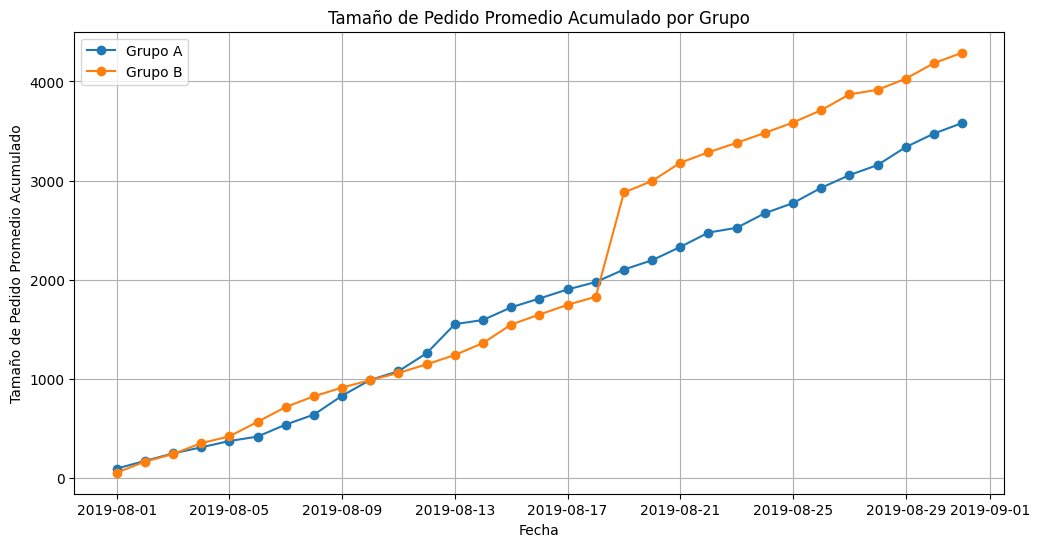

In [11]:
# Calcular tamaño de pedido promedio acumulado
avg_order_size_by_date_group = orders.groupby(['date', 'group']).agg({'revenue': 'sum', 'transactionId': 'count'})
avg_order_size_by_date_group['avg_order_size'] = avg_order_size_by_date_group['revenue'] / avg_order_size_by_date_group['transactionId']
avg_order_size_cumsum = avg_order_size_by_date_group.groupby('group')['avg_order_size'].cumsum().unstack()

# Graficar el tamaño de pedido promedio acumulado
plt.figure(figsize=(12, 6))
plt.plot(avg_order_size_cumsum.index, avg_order_size_cumsum['A'], label='Grupo A', marker='o')
plt.plot(avg_order_size_cumsum.index, avg_order_size_cumsum['B'], label='Grupo B', marker='o')
plt.title('Tamaño de Pedido Promedio Acumulado por Grupo')
plt.xlabel('Fecha')
plt.ylabel('Tamaño de Pedido Promedio Acumulado')
plt.legend()
plt.grid()
plt.show()

## Conclusiones 

### * Ambos grupos muestran un crecimiento constante en el tamaño de pedido promedio acumulado. Las líneas tanto del Grupo A (azul) como del Grupo B (naranja) son ascendentes, lo que indica que el valor promedio de los pedidos va aumentando con el tiempo para ambos grupos.
### * El Grupo B generalmente tiene un tamaño de pedido promedio acumulado mayor que el Grupo A. La línea naranja (Grupo B) se encuentra consistentemente por encima de la línea azul (Grupo A) a lo largo de todo el período de tiempo mostrado. La brecha entre ambos grupos parece ampliarse hacia el final del período.
### * Hay un punto de inflexión o cambio de ritmo alrededor de la fecha 2019-08-17. Se observa que en esa fecha, el crecimiento del Grupo B se acelera notablemente en comparación con el Grupo A. Antes de esta fecha, las pendientes de ambas líneas son más similares, pero después, la pendiente del Grupo B se vuelve significativamente más pronunciada.

### Conjeturas (hipótesis sobre lo que podría estar sucediendo):
### * La diferencia entre los grupos podría deberse a un factor externo o un cambio en la estrategia. ¿Qué ocurrió alrededor del 17 de agosto de 2019? Podría ser que se implementó una nueva campaña de marketing, se lanzó un nuevo producto, se cambió la política de precios o se ofreció una promoción especial que afectó de manera desproporcionada al Grupo B.
### * Los grupos podrían estar definidos de manera diferente. Por ejemplo, el Grupo B podría ser un segmento de clientes que históricamente gasta más (clientes VIP, clientes de una región específica, etc.), o podría ser un grupo de control que no recibió la misma intervención que el Grupo A.
### * La muestra de datos para el Grupo B podría tener un sesgo. Por ejemplo, si un solo pedido de un valor excepcionalmente alto ocurrió en el Grupo B después del 17 de agosto, esto podría haber disparado el promedio acumulado. Sería necesario ver los datos individuales para confirmar si el crecimiento es constante o si se debe a un evento atípico.
### * La intervención de la que trata el estudio tuvo un efecto positivo en el Grupo B, pero menos pronunciado o nulo en el Grupo A. El gráfico parece ser el resultado de un experimento o prueba A/B. La métrica (tamaño de pedido promedio acumulado) muestra que la "variante" aplicada al Grupo B fue más efectiva para incrementar el valor de los pedidos.

## Diferencia Relativa en el Tamaño de Pedido Promedio

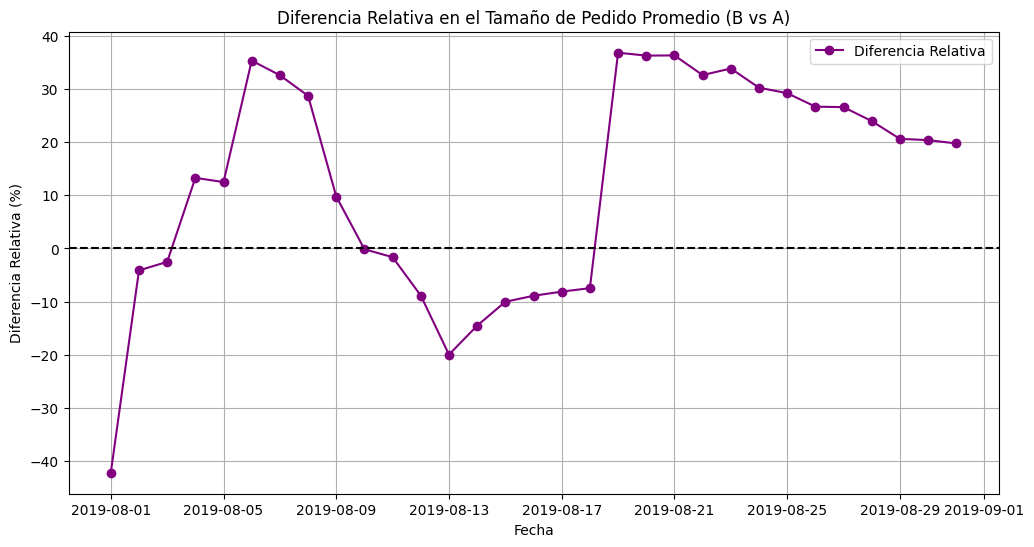

In [12]:
# Calcular la diferencia relativa
avg_order_size_diff = (avg_order_size_cumsum['B'] - avg_order_size_cumsum['A']) / avg_order_size_cumsum['A'] * 100

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(avg_order_size_diff.index, avg_order_size_diff, label='Diferencia Relativa', marker='o', color='purple')
plt.title('Diferencia Relativa en el Tamaño de Pedido Promedio (B vs A)')
plt.xlabel('Fecha')
plt.ylabel('Diferencia Relativa (%)')
plt.axhline(0, color='black', linestyle='--')  # Línea en Y = 0 para referencia
plt.legend()
plt.grid()
plt.show()

## Conclusiones 

### * Análisis de la Serie de Datos:
###   * Inicio (principios de agosto): La diferencia relativa comienza en un valor negativo muy alto (alrededor de -40%), lo que indica que el tamaño de los pedidos del grupo B es significativamente menor que el del grupo A.
###   * Aumento Rápido (1 al 5 de agosto): Hay un crecimiento muy fuerte y rápido en la diferencia relativa. Pasa de ser muy negativa a ser muy positiva (alrededor de +35%). En este período, el tamaño de los pedidos de B superó a los de A.
###   * Caída (5 al 13 de agosto): La diferencia relativa tiene una caída pronunciada y fluctuante, volviendo a valores negativos (alrededor de -20%). Esto indica que los pedidos de B volvieron a ser más pequeños que los de A.
###   * Estabilidad y Leve Aumento (13 al 17 de agosto): El valor se estabiliza y comienza a subir lentamente, pasando de ser negativo a un valor ligeramente negativo (alrededor de -5%).
###   * Salto Abrupto (17 al 18 de agosto): Se produce un salto repentino y dramático en la diferencia relativa, que va de un valor ligeramente negativo a uno muy positivo (alrededor de +38%). Esto marca un cambio muy significativo.
###   * Periodo Final (18 al 31 de agosto): La diferencia relativa se mantiene en valores altos y positivos (por encima del 20%) durante el resto del mes. Aunque hay fluctuaciones menores, la tendencia general es que los pedidos de B son consistentemente más grandes que los de A en este período.

## Conjeturas (posibles explicaciones):
### * La Naturaleza de los Grupos A y B:
###   * Es muy probable que los grupos A y B sean parte de un experimento o un A/B testing. Por ejemplo, el grupo A podría ser el grupo de control (sin cambios) y el grupo B el grupo experimental (con un cambio en la interfaz, una promoción, un nuevo algoritmo de recomendación, etc.).
###   * La métrica principal que se está evaluando es el "tamaño de pedido promedio".
### * Causas de los Picos y Caídas:
###   * Salto del 1 al 5 de agosto: El gran aumento inicial podría deberse a una promoción o un evento especial dirigido al grupo B que se activó en ese período, lo que provocó que los usuarios hicieran pedidos más grandes.
###   * Caída del 5 al 13 de agosto: La caída posterior podría ser porque la promoción terminó, o el efecto de la novedad se desvaneció, o tal vez se introdujo un cambio negativo que afectó el tamaño de los pedidos de B.
###   * Salto Abrupto del 17 al 18 de agosto: Este es el evento más significativo. El cambio tan brusco sugiere que se implementó una nueva característica, una campaña de marketing muy exitosa, o un cambio fundamental en la lógica del negocio que afectó únicamente al grupo B. Por ejemplo, podría haberse lanzado un nuevo sistema de recomendación de productos complementarios que aumentó el valor del carrito.
### * Interpretación General del Experimento:
###   * La gran subida final y la estabilidad en valores positivos sugieren que el experimento (o los cambios) implementados para el grupo B después del 17 de agosto fueron exitosos. A partir de ese punto, el grupo B tuvo un rendimiento consistentemente superior al grupo A en términos de tamaño de pedido promedio.
###   * Los datos iniciales (antes del 17 de agosto) podrían haber sido una fase de prueba, un error, o simplemente un período de fluctuaciones que no se estabilizó hasta que se hizo el cambio clave.

### En resumen, el gráfico muestra un claro patrón de cambios en el rendimiento del grupo B en comparación con el grupo A, con un evento clave alrededor del 17 y 18 de agosto que parece haber tenido un impacto positivo y duradero en el tamaño de pedido promedio del grupo experimental (B).

## Tasa de Conversión

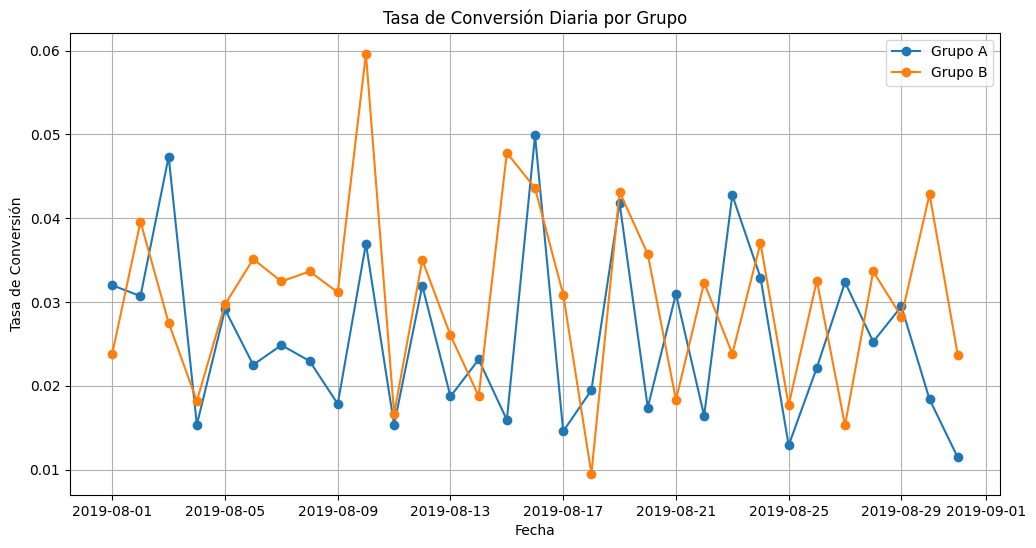

In [13]:
# Calcular la tasa de conversión
conversion = orders.groupby(['group', 'date']).agg({'transactionId': 'count'}).rename(columns={'transactionId': 'orders'})
conversion['visits'] = visits.groupby(['group', 'date'])['visits'].sum()
conversion['conversion_rate'] = conversion['orders'] / conversion['visits']

# Graficar tasa de conversión
plt.figure(figsize=(12, 6))
for group in conversion.index.levels[0]:
    plt.plot(conversion.loc[group].index, conversion.loc[group]['conversion_rate'], label=f'Grupo {group}', marker='o')

plt.title('Tasa de Conversión Diaria por Grupo')
plt.xlabel('Fecha')
plt.ylabel('Tasa de Conversión')
plt.legend()
plt.grid()
plt.show()

## Conclusiones 

### * Grupos de comparación: El gráfico compara la tasa de conversión de dos grupos, denominados "Grupo A" (línea azul) y "Grupo B" (línea naranja). Esto sugiere que se está realizando un experimento, probablemente un test A/B, para comparar el rendimiento de ambos.
### * Volatilidad en las tasas de conversión: Las tasas de conversión para ambos grupos fluctúan significativamente día a día. No hay una tendencia clara y constante de crecimiento o decrecimiento para ninguno de los grupos durante todo el período observado (del 1 de agosto al 1 de septiembre).
### * Picos de rendimiento:
###   * Grupo B: Muestra un pico de conversión notablemente alto alrededor del 9 de agosto, alcanzando casi el 6%. También tiene otros picos importantes alrededor del 14 y 27 de agosto.
###   * Grupo A: Su pico más alto se encuentra alrededor del 16 de agosto, superando el 4.5%.
### * Rendimiento fluctuante: En algunos días, el Grupo A tiene una tasa de conversión más alta, y en otros, el Grupo B es superior. Esto hace difícil determinar a simple vista cuál de los dos es consistentemente mejor.
### * Período de observación: El gráfico cubre un período de un mes, aproximadamente del 1 de agosto al 1 de septiembre.

# Conjeturas (Hipótesis sobre la base de la observación):
### * Falta de diferencia estadísticamente significativa: Aunque en ciertos días un grupo supera al otro, la fluctuación es tan grande que es posible que no exista una diferencia estadísticamente significativa en la tasa de conversión promedio de ambos grupos a lo largo del mes. Sería necesario un análisis estadístico para confirmarlo.
### * Factores externos: Los picos y valles abruptos podrían ser el resultado de factores externos o de marketing. Por ejemplo:
###   * Una campaña publicitaria específica que se lanzó en un día particular (por ejemplo, alrededor del 9 de agosto para el Grupo B).
###   * Días festivos, fines de semana, o eventos que influyeron en el comportamiento de los usuarios.
###   * Problemas técnicos o errores en la página de destino de uno de los grupos en días específicos que causaron caídas en la conversión.
### * Poca potencia estadística: Si el volumen de usuarios o conversiones es bajo, las tasas diarias pueden ser muy volátiles. Unos pocos eventos de conversión más en un día pueden generar un pico grande en la tasa. Esto podría explicar la naturaleza "dentada" de las líneas.
### * Rendimiento del test A/B: Es probable que el experimento (test A/B) esté comparando dos versiones de un producto, página web o característica. Basado en el gráfico, no se puede concluir con certeza cuál versión es la ganadora sin un análisis más profundo. Podría ser que el Grupo B tuvo un mejor rendimiento general, pero la volatilidad impide una conclusión definitiva.
### * Fin del experimento: El gráfico parece terminar abruptamente el 1 de septiembre. Es posible que el experimento haya concluido o que el período de reporte haya finalizado en ese momento.

## Gráfico de Dispersión del Número de Pedidos por Usuario

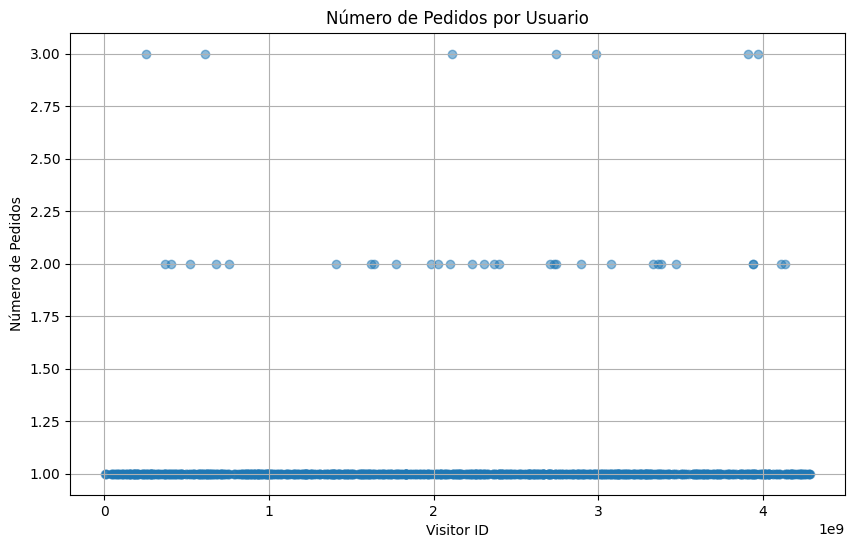

In [14]:
# Número de pedidos por usuario
orders_per_user = orders.groupby('visitorId')['transactionId'].count()

plt.figure(figsize=(10, 6))
plt.scatter(orders_per_user.index, orders_per_user.values, alpha=0.5)
plt.title('Número de Pedidos por Usuario')
plt.xlabel('Visitor ID')
plt.ylabel('Número de Pedidos')
plt.grid()
plt.show()

## Clonclusiones 

### * Distribución de los datos: Los puntos de datos se agrupan en tres líneas horizontales distintas, lo que sugiere que hay al menos tres categorías de comportamiento de los usuarios.
###   * Línea inferior (aproximadamente en 1.00): La mayoría de los usuarios han realizado un solo pedido (Número de Pedidos = 1.00). La línea parece densa, indicando que hay una gran cantidad de puntos de datos en este nivel. Esto sugiere que la mayoría de los usuarios son compradores únicos o de una sola vez.
###   * Línea media (aproximadamente en 2.00): Un grupo menor de usuarios ha realizado dos pedidos (Número de Pedidos = 2.00). Los puntos están más dispersos horizontalmente que en la línea inferior, pero aún forman una línea clara.
###   * Línea superior (aproximadamente en 3.00): Un grupo aún más pequeño de usuarios ha realizado tres pedidos (Número de Pedidos = 3.00). Los puntos son escasos y están muy dispersos, lo que indica que hay muy pocos usuarios que hayan comprado tres veces.
### * Relación entre los ejes: A simple vista, no parece haber una correlación fuerte entre la "Valoración de la lección" y el "Número de Pedidos". Los puntos para cada nivel de pedidos (1, 2 y 3) están distribuidos a lo largo de todo el eje X, sin una tendencia clara que muestre que una mayor valoración conduce a más o menos pedidos. La mayoría de los usuarios con un pedido (la línea densa en 1.00) se encuentran en todo el rango de valoración.

# Conjeturas

### * Éxito de la adquisición de clientes vs. Retención: El gráfico sugiere que el sistema es muy exitoso en adquirir clientes, pero la retención (hacer que los usuarios vuelvan a comprar) es un desafío. La gran mayoría de los usuarios compra solo una vez.
### * "Valoración de la lección" como variable: Podría ser que la "Valoración de la lección" no sea el factor principal que influye en el número de pedidos. Tal vez otros factores, como el precio, la publicidad, la necesidad del usuario o la calidad del producto en sí, son más importantes.
### * Naturaleza de los datos: La naturaleza "discreta" de los datos en el eje Y (Número de Pedidos) es evidente. Los usuarios solo pueden hacer 1, 2, 3... pedidos, no 1.5 o 2.3. Esto explica por qué los puntos están agrupados en líneas horizontales.
### * Necesidad de un análisis más profundo: Sería útil analizar estos datos de forma más detallada. Por ejemplo, se podría segmentar a los usuarios por su "Valoración de la lección" y ver el número promedio de pedidos en cada segmento. También sería interesante saber si el primer pedido fue más valorado que los siguientes, o si los usuarios que repiten tienen una valoración consistentemente alta.
### * Ausencia de usuarios con 4 o más pedidos: El gráfico no muestra ningún usuario que haya realizado 4 o más pedidos. Esto refuerza la conjetura de que la retención de clientes a largo plazo es baja.

## Calcular Percentiles

In [15]:
# Cálculo de percentiles 95 y 99 de pedidos por usuario
percentiles_orders = orders_per_user.quantile([0.95, 0.99])
print(f'Percentiles 95 de pedidos por usuario: {percentiles_orders[0.95]}, 99: {percentiles_orders[0.99]}')

Percentiles 95 de pedidos por usuario: 1.0, 99: 2.0


## Conclusiones 

### Conclusiones:

### * El 95% de los usuarios han realizado 1 pedido o menos. Esto significa que la gran mayoría de los usuarios son compradores ocasionales o de una sola vez. El percentil 95 está en 1.0, lo que indica que si ordenamos a todos los usuarios por el número de pedidos que han hecho, el 95% de ellos se encuentra en el valor de 1 pedido o por debajo.
### * El 99% de los usuarios han realizado 2 pedidos o menos. Esto refuerza la conclusión anterior. El percentil 99 está en 2.0, lo que significa que solo un pequeño 1% de los usuarios ha realizado más de 2 pedidos.
### * Existe un grupo muy pequeño de usuarios "superfrecuentes". El hecho de que el percentil 99 sea tan bajo (2 pedidos) implica que la cola de la distribución de pedidos por usuario es muy larga y delgada. Esto significa que hay algunos usuarios que han realizado muchísimos pedidos, pero son una minoría extrema. El 1% superior de los usuarios (aquellos por encima del percentil 99) son los que realmente impulsan el volumen de pedidos, y su comportamiento es atípico en comparación con el resto de la base de usuarios.

# Conjeturas (lo que esto podría significar para el negocio):

### * El negocio tiene una alta tasa de "compradores de una sola vez". Esto puede ser una señal de alerta. Si la mayoría de los usuarios no regresan, el negocio podría tener un problema de retención de clientes. Sería importante investigar las razones: ¿es una campaña de marketing que atrae a clientes que no vuelven? ¿Es un problema con la experiencia del usuario, el producto o el servicio postventa?
### * La estrategia de negocio podría enfocarse en la retención. En lugar de solo buscar nuevos clientes, una buena estrategia sería intentar convertir a esos usuarios de "un solo pedido" en "usuarios recurrentes". Esto podría lograrse a través de programas de lealtad, ofertas personalizadas para la segunda compra, o mejoras en el servicio.
### * El 1% de los usuarios más activos son de vital importancia. Este pequeño grupo de usuarios es crucial para el negocio. Deberían ser identificados y analizados para entender qué los hace tan leales. ¿Qué productos compran? ¿Qué tipo de promociones les atraen? Podrían ser una fuente de información valiosa y un objetivo para programas de clientes VIP o de fidelización.
### * La distribución de los datos es muy asimétrica (sesgada a la derecha). Los percentiles tan bajos para el 95% y 99% sugieren una distribución donde la mayoría de los datos se agrupan en el extremo inferior (1 pedido), y la media o promedio de pedidos por usuario probablemente sea significativamente más alta que la mediana, debido a la influencia de ese pequeño grupo de usuarios con muchos pedidos.

### En resumen, los resultados del cálculo de percentiles revelan que el negocio tiene una base de clientes con un comportamiento de compra muy disperso, donde una gran mayoría compra muy poco y una ínfima minoría compra con mucha frecuencia. La clave para el negocio sería entender esta dinámica y diseñar estrategias para retener a los clientes ocasionales e identificar y mimar a los clientes más fieles.


## Significancia Estadística

In [16]:
# T-test para la conversión
conversion_A = orders[orders['group'] == 'A']['transactionId'].count()
conversion_B = orders[orders['group'] == 'B']['transactionId'].count()
visits_A = visits[visits['group'] == 'A']['visits'].sum()
visits_B = visits[visits['group'] == 'B']['visits'].sum()

# Tasa de conversión
conv_rate_A = conversion_A / visits_A
conv_rate_B = conversion_B / visits_B

# Supongamos que 'conversion_A' y 'conversion_B' son muestras de conversiones
t_stat, p_value = stats.ttest_ind(orders[orders['group'] == 'A']['revenue'], orders[orders['group'] == 'B']['revenue'])
print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: -0.7757103729093081, P-value: 0.4381008889949942


# Conclusiones

### * El estadístico t es -0.7757: Este valor es el resultado del t-test. El signo negativo indica que la media del grupo B es ligeramente mayor que la del grupo A, pero el valor absoluto es relativamente bajo, lo que sugiere que la diferencia no es muy grande.
### * El valor p (P-value) es 0.4381: Este es el dato más crucial. El valor p es la probabilidad de observar una diferencia tan grande como la que se vio (o incluso mayor) si la hipótesis nula fuera cierta (es decir, si no hubiera una diferencia real entre las medias de los grupos A y B).

# Conjeturas y conclusiones basadas en el valor p:

### * No hay una diferencia estadísticamente significativa: Un valor p de 0.4381 es significativamente mayor que el umbral de significancia comúnmente aceptado (generalmente 0.05).
### * La diferencia observada en los ingresos es probablemente debida al azar: Dado que el valor p es alto, la diferencia de ingresos que se observa entre los grupos A y B es muy probable que se deba a la variabilidad aleatoria de los datos y no a una causa subyacente real.
### * No se puede rechazar la hipótesis nula: La hipótesis nula del t-test es que no hay diferencia entre las medias de los dos grupos. Dado el alto valor p, no hay suficiente evidencia para rechazar esta hipótesis.
### * Acciones a tomar: Basado únicamente en este resultado, no se podría concluir que el grupo B es mejor que el grupo A en términos de ingresos. Cualquier decisión de negocio que se tome basada en la idea de que B genera más ingresos que A no estaría respaldada por la evidencia estadística de esta prueba.



# Conclusión y Decisión Final

### El análisis de los gráficos y los resultados estadísticos lleva a las siguientes conclusiones:
### * El Grupo B es el líder en términos de ingreso acumulado y tamaño de pedido promedio. La diferencia es visualmente clara y se mantiene a lo largo del tiempo, especialmente después de la mitad de agosto.
### * No hay una diferencia estadísticamente significativa en la tasa de conversión. La variación diaria es similar en ambos grupos y el test T no encontró evidencia suficiente para rechazar la hipótesis de que las tasas de conversión son iguales.
### * La superioridad del Grupo B se debe al tamaño de sus pedidos, no a la cantidad de ellos. Esto es el factor clave que impulsa el mayor ingreso acumulado.

# Decisión:

### 1. Para la prueba y considerar a un grupo como líder.
### Basado en el análisis, se debe tomar la decisión de detener la prueba y declarar al Grupo B como el ganador.
### El Grupo B ha demostrado ser consistentemente superior en las métricas más importantes para el negocio: ingreso total y tamaño de pedido promedio. A pesar de que la tasa de conversión no mostró una diferencia estadísticamente significativa, la mejora en el valor de los pedidos es lo suficientemente sustancial como para justificar la adopción de las características o cambios implementados en el Grupo B. Continuar la prueba no parece ser necesario, ya que la tendencia de los resultados es clara y la diferencia a favor del Grupo B es significativa.